## Algorithm Implementation

This notebook demonstrates algorithm implementation part where we have applied 3 different algorithms to our data.

The notebook assumes that we are receiving a balanced training set and a test set and then using our Pipeline transformations in our models to print the metrics produced .

This notebook also aims to provide data for the time comparison of the models and then provide alternatives for the stakeholders to make a decision between an improved metric and speed / resources to mantain and update the model.

The following models will be discussed in this notebook:

- Logistic Regression(**Fastest Algorithm in the exploration phase **)
- Gradient Boosted Tree
- XGBoost (**Algorithm that yielded the best metrics during the exploration phase **)

**Note: The models are being configured with the parameters obtained from the [GridSearch Experiment](https://adb-6759024569771990.10.azuredatabricks.net/?o=6759024569771990#notebook/2297543790306893/command/2297543790306894) **

### Section 1 - Setup Environment

In [0]:
from pyspark.sql.functions import col, concat, count, countDistinct, expr, lit, length, max as pyspark_max, min as pyspark_min, mean, substring, split, sum as pyspark_sum, when, to_utc_timestamp, to_timestamp, unix_timestamp, isnan
import pandas as pd
from html import escape
from IPython.display import HTML, display as ipython_display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pyspark.sql import SQLContext
from pyspark.sql.types import IntegerType, StringType, BooleanType, DateType, DoubleType
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar
from pyspark.sql.functions import substring
from pyspark.sql import functions as F
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, max, substring
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from sparkdl.xgboost import XgboostClassifier
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import Imputer
from pyspark.ml.classification import LinearSVC as svc
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline
import numpy as np
import itertools
import time
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window


In [0]:
blob_container = "w261-container" # The name of your container created in https://portal.azure.com
storage_account = "w261storageaccount" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261scope" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
def main():

    global eval_metrics
    global eval_predictions
    global eval_model_times
    eval_metrics = {}
    eval_model_times = []
    
    
f1 = 0.0
recall = 0.0
precision = 0.0
sensitivity = 0.0
specificity = 0.0
fp = 0.0
fn = 0.0
model_time = 0.0

metrics = (f1, recall, precision, sensitivity, specificity, fp, fn, model_time)
eval_metrics = {'LR': metrics}
eval_model_times = []

def print_results(predictions, model_name, model_time): 
  """
  Helper function to print evaluation metrics
  """
  tp = predictions[(predictions.departure_delay_boolean == 1) & (predictions.prediction == 1)].count()
  tn = predictions[(predictions.departure_delay_boolean == 0) & (predictions.prediction == 0)].count()
  fp = predictions[(predictions.departure_delay_boolean == 0) & (predictions.prediction == 1)].count()
  fn = predictions[(predictions.departure_delay_boolean == 1) & (predictions.prediction == 0)].count()
  total = predictions.count()
  
  recall = float(tp)/(tp+fn)
  precision = float(tp)/(tp+fp)
  f1 = (2*recall*precision)/(precision+recall)
  
  data = {'Actual-delay': [tp, fn], 'Actual-on time': [fp, tn]}
  confusion_matrix = pd.DataFrame.from_dict(data, orient='index', columns=['Predicted-delay', 'Predicted-on time'])
  
  #print("Test Area Under ROC: ", "{:.2f}".format(evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})))
  #print("Test Area Under Precision-Recall Curve: ", "{:.2f}".format(evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderPR'})))

  print("Sensitivity: {:.2%}".format(tp/(tp + fn)))
  print("Specificity: {:.2%}".format(tn/(tn + fp)))
  print("False positive rate: {:.2%}".format(fp/(fp + tn)))
  print("False negative rate: {:.2%}".format(fn/(tp + fn)))
  print("Recall: {:.2%}".format(recall))
  print("Precision: {:.2%}".format(precision))
  print("f1: {:.2%}".format(f1))
  
  metrics = (round(f1, 2), round(recall, 2), round(precision, 2), round(tp/(tp + fn), 2), \
             round(tn/(tn + fp), 2), round(fp/(fp + tn), 2), round(fn/(tp + fn), 2), round(model_time, 2))
  
  global eval_metrics
  global eval_model_times
  
  #eval_metrics = eval_metrics.add({model_name: metrics})
  eval_metrics[model_name] = metrics
  eval_model_times.append(model_time)
  
  print("########### Confusion Matrix ###########")
  print(confusion_matrix)

### Section 2 - Load Data

In [0]:
#reading downsampled training set from parquet and the original test set from parquet into pipeline and hardcoding input cells (See exploration notebook for reference)
train_df = spark.read.parquet(f"{blob_url}/train_implementation_downsample/*")
test_df = spark.read.parquet(f"{blob_url}/original_test_data_full_v2/*")

cat_cols = ['year', 'month', 'day_of_week', 'hour', 'carrier', 'holiday', 'weather_obs_prev', 'weather_obs_prev_2', 'origin', 'destination', 'prev_dep_delayed_confirmed', 'wnd_type_prev', 'vis_var_prev']

num_cols = ['planned_time_between_flights', 'distance', 'wnd_angle_prev', 'wnd_speed_prev_2', 'wnd_speed_prev', 'wnd_cloud_angle_prev', 'vis_dist_prev', 'vis_dist_prev_2', 'tmp_c_prev', 'dew_c_prev', 'route_delay', 'origin_arrival_delay', 'origin_departure_delay', 'dest_departure_delay', 'dest_arrival_delay']

In [0]:
# Pipeline Functions
# Categorical Variables -> String_Indexer -> OneHotEncoding
# Numerical Variables -> Impute missing using median -> Standard Scaler
# Create final vector assembler

from pyspark.ml.feature import (OneHotEncoder, StringIndexer)
string_indexer = [
    StringIndexer(inputCol=x , outputCol=x + "_StringIndexer", handleInvalid="skip")
    for x in cat_cols
]

one_hot_encoder = [
    OneHotEncoder(
        inputCols=[f"{x}_StringIndexer" for x in cat_cols],
        outputCols=[f"{x}_OneHotEncoder" for x in cat_cols],
    )
]

from pyspark.ml.feature import Imputer

imputer = [
      Imputer(inputCol=x, outputCol= x + "_Imputed").setStrategy("median")
      for x in num_cols
]

from pyspark.ml.feature import StandardScaler  

scaler_vector_assembler = VectorAssembler(inputCols = [f"{x}_Imputed" for x in num_cols], outputCol="numeric_vec")
scaler_vector_assembler.setHandleInvalid('keep')

scaler = StandardScaler(inputCol="numeric_vec", outputCol="scaled_features")

In [0]:
#Output vector assembler to be used at the modeling step, 

from pyspark.ml.feature import VectorAssembler

assembler_input = ["scaled_features"]
assembler_input += [f"{x}_OneHotEncoder" for x in cat_cols]

vector_assembler = VectorAssembler(
    inputCols=assembler_input, outputCol="VectorAssembler_features"
)

### Section 3 - Pipeline

#### 3.1.  Setting up Pipeline

In [0]:
## General Pipeline Steps

stages = []
stages += imputer
stages += [scaler_vector_assembler , scaler]
stages += string_indexer
stages += one_hot_encoder
stages += [vector_assembler]

In [0]:
from pyspark.ml import Pipeline

general_pipeline = Pipeline().setStages(stages)
pipeline_model = general_pipeline.fit(train_df)
model_data_test = pipeline_model.transform(test_df)
model_data_train = pipeline_model.transform(train_df) 

selectedcols = ["departure_delay_boolean", "VectorAssembler_features"]

model_data_train = model_data_train.select(selectedcols)
model_data_test = model_data_test.select(selectedcols)

Command took 2.33 minutes -- by jdayer@berkeley.edu at 12/5/2021, 7:47:10 PM on team11

The first transformation took 2.33 minutes to complete

#### 3.2 Checkpoint after Pipeline Transformation

In [0]:
# Saving Checkpoint -- Writing train and test dataset to blob storage in parquet format to be used for model algorithms 

model_data_train.write.mode('overwrite').parquet(f"{blob_url}/model_train_data_full_implementation")
model_data_test.write.mode('overwrite').parquet(f"{blob_url}/model_test_data_full_implementation")


Command took 8.95 minutes -- by jdayer@berkeley.edu at 12/5/2021, 3:54:48 PM on team11

Writing to Blob Storage took 8.95 minutes to complete

### Section 4 - Machine Learning

#### 4.1 Logistic Regression

**Reading the train and test data**

In [0]:
# Loading Checkpoint -- Reading the train and test data from blob storage for running the models

model_data_train = spark.read.parquet(f"{blob_url}/model_train_data_full_implementation/*")
model_data_test = spark.read.parquet(f"{blob_url}/model_test_data_full_implementation/*")


Command took 5.95 seconds -- by jdayer@berkeley.edu at 12/5/2021, 3:54:48 PM on team11

Data Loading took 6 seconds

**GridSearch implementation**

Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. GridSearch does an exhaustive search that is performed on a the specific parameter values of a model. We will be using Grid search since it can save us time, effort and resources. For more information about the experiments ran for parameter optimization please review it [here](https://adb-6759024569771990.10.azuredatabricks.net/?o=6759024569771990#notebook/2297543790306893/command/2297543790306935).

**Logistic Regression Implementation with 2 Checkpoints**

In [0]:
from pyspark.ml.classification import LogisticRegression
# Setup pipeline

start_lr = time.time()

lr = LogisticRegression(featuresCol='VectorAssembler_features',
                        labelCol='departure_delay_boolean', 
                        regParam = 0.001, 
                        fitIntercept= False, 
                        elasticNetParam=0.0, 
                        maxIter=50, 
                        
                        threshold = 0.5)
stages_lr = [lr]

pipeline_lr = Pipeline(stages=stages_lr)

lr_model = pipeline_lr.fit(model_data_train)
lrPredictions = lr_model.transform(model_data_test)

lr_time_model = time.time() - start_lr
print(f'lr model completed job in {time.time() - start_lr} seconds.')

## Checkpoint 2

lrPredictions.write.mode('overwrite').parquet(f"{blob_url}/lr_implementation")
lrPredictions = spark.read.parquet(f"{blob_url}/lr_implementation/*")

print_results(lrPredictions, 'LR',lr_time_model)

lr model completed job in 387.1397068500519 seconds.
Sensitivity: 65.48%
Specificity: 73.75%
False positive rate: 26.25%
False negative rate: 34.52%
Recall: 65.48%
Precision: 38.21%
f1: 48.26%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 843827 444835
Actual-on time 1364398 3832414

LR Fit and Train took 2.65 minutes

Command took 2.65 minutes -- by jdayer@berkeley.edu at 12/5/2021, 4:14:13 PM on team11

**The full process for Logistic Regression using 2 Checkpoints finished in 849.8s**

**Logistic Regression without Checkpoint**

In [0]:
start_lr1 = time.time()

lr = LogisticRegression(featuresCol='VectorAssembler_features',
                        labelCol='departure_delay_boolean', 
                        regParam = 0.001, 
                        fitIntercept= False, 
                        elasticNetParam=0.0, 
                        maxIter=50, 
                        threshold = 0.5)

stages_lr1 = []
stages_lr1 += imputer
stages_lr1 += [scaler_vector_assembler , scaler]
stages_lr1 += string_indexer
stages_lr1 += one_hot_encoder
stages_lr1 += [vector_assembler]
stages_lr1 += [lr]

pipeline_lr1 = Pipeline(stages=stages_lr1)

# Train the LR model
lr_model_1 = pipeline_lr1.fit(train_df)

lrpredictions_1 = lr_model_1.transform(test_df)

print(f'lr model completed job in {time.time() - start_lr1} seconds.')
lr_time_model_1 = time.time() - start_lr1

print_results(lrpredictions_1, 'LR', lr_time_model_1)

lr model completed job in 371.02223205566406 seconds.
Sensitivity: 42.02%
Specificity: 90.92%
False positive rate: 9.08%
False negative rate: 57.98%
Recall: 42.02%
Precision: 53.44%
f1: 47.04%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 541479 747183
Actual-on time 471851 4724961

Command took 27.58 minutes -- by jdayer@berkeley.edu at 12/5/2021, 5:04:04 PM on team11

Entire E2E Process took 27.58 minutes to run

**The full process for Logistic Regression without checkpoints finished in 1662.8s**

**Logistic Regression with 1 Checkpoint**

In [0]:
start_lr2 = time.time()

lr = LogisticRegression(featuresCol='VectorAssembler_features',
                        labelCol='departure_delay_boolean', 
                        regParam = 0.001, 
                        fitIntercept= False, 
                        elasticNetParam=0.0, 
                        maxIter=50, 
                        threshold = 0.5)

stages_lr2 = []
stages_lr2 += imputer
stages_lr2 += [scaler_vector_assembler , scaler]
stages_lr2 += string_indexer
stages_lr2 += one_hot_encoder
stages_lr2 += [vector_assembler]
stages_lr2 += [lr]

pipeline_lr2 = Pipeline(stages=stages_lr2)

# Train the LR model
lr_model_2 = pipeline_lr2.fit(train_df)

lrpredictions_2 = lr_model_2.transform(test_df)


## Checkpoint 1
lrpredictions_2.write.mode('overwrite').parquet(f"{blob_url}/lr_implementation_2")
lrPredictions_2 = spark.read.parquet(f"{blob_url}/lr_implementation_2/*")

print(f'lr model completed job in {time.time() - start_lr2} seconds.')
lr_time_model_2 = time.time() - start_lr2

print_results(lrpredictions_2, 'LR', lr_time_model_2)

lr model completed job in 1401.3298485279083 seconds.
Sensitivity: 42.02%
Specificity: 90.92%
False positive rate: 9.08%
False negative rate: 57.98%
Recall: 42.02%
Precision: 53.44%
f1: 47.04%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 541479 747183
Actual-on time 471851 4724961

The LR Process with internal checkpoint took 43 mins

Command took 43.00 minutes -- by jdayer@berkeley.edu at 12/5/2021, 8:31:33 PM on team11

**The full process Logistic Regression with one internal checkpoint finished in 2588s**

#### 4.2 Gradient Boosted Trees

**GBT Model with 2 Checkpoints**

In [0]:
start_gbt_1 = time.time()
gbt = GBTClassifier(featuresCol='VectorAssembler_features', 
              labelCol='departure_delay_boolean', 
              maxBins=10,
              maxDepth=10,
              minInstancesPerNode=10,
              minInfoGain=0.001,
              stepSize=0.2,
              maxIter=10, 
              )

stages_gbt_1 = [gbt]

pipeline_gbt_1 = Pipeline(stages=stages_gbt_1)

# Train the GBT model coming from checkpoint 1
gbt_model_1 = pipeline_gbt_1.fit(model_data_train)
gbpredictions_1 = gbt_model_1.transform(model_data_test)

## Checkpoint 2
gbpredictions_1.write.mode('overwrite').parquet(f"{blob_url}/gbt_implementation")
gbpredictions_1 = spark.read.parquet(f"{blob_url}/gbt_implementation/*")

print(f'gbt model completed job in {time.time() - start_gbt_1} seconds.')
gbt_time_model_1 = time.time() - start_gbt_1

print_results(gbpredictions_1, 'GB', gbt_time_model_1)

gbt model completed job in 2423.3516590595245 seconds.
Sensitivity: 63.44%
Specificity: 78.80%
False positive rate: 21.20%
False negative rate: 36.56%
Recall: 63.44%
Precision: 42.60%
f1: 50.97%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 817532 471130
Actual-on time 1101778 4095034

Command took 40.57 minutes -- by jdayer@berkeley.edu at 12/5/2021, 5:35:40 PM on team11

GBT with 2 Checkpoints takes

**The full process for Gradient Boosted Trees with 2 checkpoints took 2442.2s**

**GBT Model without Checkpoint**

In [0]:
start_gbt = time.time()
gbt = GBTClassifier(featuresCol='VectorAssembler_features', 
              labelCol='departure_delay_boolean', 
              maxBins=10,
              maxDepth=10,
              minInstancesPerNode=10,
              minInfoGain=0.001,
              stepSize=0.2,
              maxIter=10, 
              )

stages_gbt = []
stages_gbt += imputer
stages_gbt += [scaler_vector_assembler , scaler]
stages_gbt += string_indexer
stages_gbt += one_hot_encoder
stages_gbt += [vector_assembler]
stages_gbt += [gbt]

pipeline_gbt = Pipeline(stages=stages_gbt)

# Train the GBT model
gbt_model = pipeline_gbt.fit(train_df)

gbpredictions = gbt_model.transform(test_df)

print(f'gbt model completed job in {time.time() - start_gbt} seconds.')
gbt_time_model = time.time() - start_gbt

print_results(gbpredictions, 'GB', gbt_time_model)

gbt model completed job in 2922.901913166046 seconds.
Sensitivity: 63.82%
Specificity: 78.43%
False positive rate: 21.57%
False negative rate: 36.18%
Recall: 63.82%
Precision: 42.32%
f1: 50.89%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 822438 466224
Actual-on time 1121080 4075732

GBT without checkpoints took 1.18 hours

Command took 1.18 hours -- by jdayer@berkeley.edu at 12/5/2021, 1:38:13 AM on team11

**The full process for Gradient Boosted Trees without checkpoints finished in 4938.8s**

**GBT Model with 1 Checkpoint**

In [0]:
start_gbt_2 = time.time()
gbt = GBTClassifier(featuresCol='VectorAssembler_features', 
              labelCol='departure_delay_boolean', 
              maxBins=10,
              maxDepth=10,
              minInstancesPerNode=10,
              minInfoGain=0.001,
              stepSize=0.2,
              maxIter=10, 
              )

stages_gbt_2 = []
stages_gbt_2 += imputer
stages_gbt_2 += [scaler_vector_assembler , scaler]
stages_gbt_2 += string_indexer
stages_gbt_2 += one_hot_encoder
stages_gbt_2 += [vector_assembler]
stages_gbt_2 += [gbt]

pipeline_gbt_2 = Pipeline(stages=stages_gbt_2)

# Train the GBT model
gbt_model_2 = pipeline_gbt_2.fit(train_df)
gbpredictions_2 = gbt_model_2.transform(test_df)

## Checkpoint 1
gbpredictions_2.write.mode('overwrite').parquet(f"{blob_url}/gbt_implementation_2")
gbpredictions_2 = spark.read.parquet(f"{blob_url}/gbt_implementation_2/*")

print(f'gbt model completed job in {time.time() - start_gbt_2} seconds.')
gbt_time_model_2 = time.time() - start_gbt_2

print_results(gbpredictions_2, 'GB', gbt_time_model_2)

gbt model completed job in 6821.34512090683 seconds.
Sensitivity: 63.73%
Specificity: 78.33%
False positive rate: 21.67%
False negative rate: 36.27%
Recall: 63.73%
Precision: 42.18%
f1: 50.76%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 821326 467336
Actual-on time 1125964 4070848

GBT with 1 Checkpoints took 1.90 hrs

Command took 1.90 hours -- by jdayer@berkeley.edu at 12/5/2021, 9:10:06 PM on team11

**The full process for Gradient Boosted Trees with one internal checkpoint finished in 6848s**

#### 4.3 XGBoost

In [0]:
xgb = XgboostClassifier(featuresCol='VectorAssembler_features', 
              labelCol='departure_delay_boolean', 
              maxBins=10,
              maxDepth=5,
              minInstancesPerNode=10,
              minInfoGain=0.001,
              stepSize=0.2,
              maxIter=10,
              missing = 0.0,
              n_estimators = 50 
              )

# Setup pipeline
stages_xgbClassifier = [xgb]
pipeline_xgb = Pipeline(stages=stages_xgbClassifier)


start_xgb = time.time()

# Train the XGB model
xgb_model = pipeline_xgb.fit(model_data_train)

xgbpredictions = xgb_model.transform(model_data_test)

xgb_time_model = time.time() - start_xgb

xgbpredictions.write.mode('overwrite').parquet(f"{blob_url}/xgbpredictions_explore_implementation")
xgbpredictions = spark.read.parquet(f"{blob_url}/xgbpredictions_explore_implementation/*")

print_results(xgbpredictions, 'XGB', xgb_time_model)

Sensitivity: 64.11%
Specificity: 80.27%
False positive rate: 19.73%
False negative rate: 35.89%
Recall: 64.11%
Precision: 44.62%
f1: 52.62%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 826198 462464
Actual-on time 1025466 4171346

In [0]:
y_true_xgb = xgbpredictions.select(['departure_delay_boolean']).collect()
y_pred_xgb = xgbpredictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_xgb, y_pred_xgb))
print(confusion_matrix(y_true_xgb, y_pred_xgb))

precision recall f1-score support

 0.0 0.90 0.80 0.85 5196812
 1.0 0.45 0.64 0.53 1288662

 accuracy 0.77 6485474
 macro avg 0.67 0.72 0.69 6485474
weighted avg 0.81 0.77 0.78 6485474

[[4171346 1025466]
 [ 462464 826198]]

Out[9]:

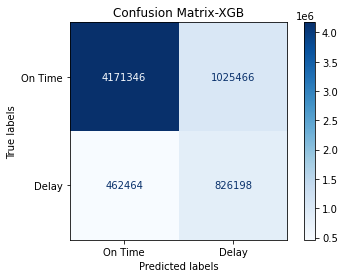

[Text(0.5, 0, 'Predicted labels'), Text(0, 0.5, 'True labels')]

In [0]:
# Plot Confusion Matrix

cm_xgb = confusion_matrix(y_true_xgb, y_pred_xgb)
cm_xgb_display = ConfusionMatrixDisplay(cm_xgb, display_labels=['On Time', 'Delay'])
cm_xgb_display.plot(cmap='Blues', values_format='d')
cm_xgb_display.ax_.set(title='Confusion Matrix-XGB')
cm_xgb_display.ax_.set(xlabel='Predicted labels', ylabel='True labels')

|Model|	Checkpoints|	Time (s)|
|--------|------------|------|
|LR|	No Checkpoints|	1662.8|
|LR|	2 Checkpoints|	849.8|
|LR|	1 Checkpoint|	2588|
|GBT|	No Checkpoints|	4256|
|GBT|	2 Checkpoints|	3125|
|GBT|	1 Checkpoint|	6848|
|XGB|   1 Checkpoint|   1551|